In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_EEG_Wrapper(DEVICE, classifier, input_dim[0],
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{EPOCH}.pt"
#            )
#     )

#     pickle.dump( model.return_pairwise_weights(), 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "wb") 
#                )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     pickle.load( 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "rb") 
#                )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6677641763406641


Iterations:   0%|                                   | 1/300 [00:02<12:39,  2.54s/it]

Epoch:  0
t_loss:  0.6677641763406641 , v_loss:  0.6962723334630331
t_acc:  0.5415499533146592 , v_acc:  0.30434782608695654
t_recall:  0.47494681654108506 , v_recall:  0.479009009009009
t_prec:  0.4763457506407925 , v_prec:  0.3506410256410256
t_f:  0.4749926036922413 , v_f:  0.24539671911617006
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:28,  1.50s/it]

Epoch  1 , loss 0.6381852171000313
Epoch  2 , loss 0.6120595441145056


Iterations:   1%|▎                                  | 3/300 [00:04<06:32,  1.32s/it]

Epoch:  2
t_loss:  0.6120595441145056 , v_loss:  0.6994553009668986
t_acc:  0.6187363834422658 , v_acc:  0.30434782608695654
t_recall:  0.5039746915359383 , v_recall:  0.4515315315315315
t_prec:  0.5051619465671986 , v_prec:  0.37716894977168947
t_f:  0.4979426865654888 , v_f:  0.2698412698412698
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:22,  1.09s/it]

Epoch  3 , loss 0.5908576723407296
Epoch  4 , loss 0.5737458525919447


Iterations:   2%|▌                                  | 5/300 [00:06<05:20,  1.09s/it]

Epoch:  4
t_loss:  0.5737458525919447 , v_loss:  0.6947305003801981
t_acc:  0.6619981325863679 , v_acc:  0.4720496894409938
t_recall:  0.5054549072892219 , v_recall:  0.4302702702702703
t_prec:  0.5130986305402917 , v_prec:  0.43855192124483966
t_f:  0.47395587722715443 , v_f:  0.42943506358140504
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:46,  1.03it/s]

Epoch  5 , loss 0.5654517716052485
Epoch  6 , loss 0.5372224385831871


Iterations:   2%|▊                                  | 7/300 [00:08<04:57,  1.01s/it]

Epoch:  6
t_loss:  0.5372224385831871 , v_loss:  0.6775240302085876
t_acc:  0.6788048552754435 , v_acc:  0.639751552795031
t_recall:  0.5040213557321476 , v_recall:  0.46396396396396394
t_prec:  0.5173783417226503 , v_prec:  0.3366013071895425
t_f:  0.4512607801134874 , v_f:  0.39015151515151514
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:30,  1.08it/s]

Epoch  7 , loss 0.5274638966018078
Epoch  8 , loss 0.5166685838325351


Iterations:   3%|█                                  | 9/300 [00:09<04:49,  1.01it/s]

Epoch:  8
t_loss:  0.5166685838325351 , v_loss:  0.6610934138298035
t_acc:  0.6859632741985683 , v_acc:  0.6894409937888198
t_recall:  0.501978424671635 , v_recall:  0.5
t_prec:  0.5149038461538461 , v_prec:  0.3447204968944099
t_f:  0.434733893557423 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:24,  1.10it/s]

Epoch  9 , loss 0.5019342525332582
Epoch  10 , loss 0.4948845873860752


Iterations:   4%|█▏                                | 11/300 [00:11<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.4948845873860752 , v_loss:  0.6583021481831869
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5066448442925571 , v_recall:  0.5
t_prec:  0.5780526208312285 , v_prec:  0.3447204968944099
t_f:  0.4348323390999881 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:22,  1.10it/s]

Epoch  11 , loss 0.48759763731675987
Epoch  12 , loss 0.48577042362269235


Iterations:   4%|█▍                                | 13/300 [00:13<04:41,  1.02it/s]

Epoch:  12
t_loss:  0.48577042362269235 , v_loss:  0.6611925065517426
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.503993219966786 , v_recall:  0.5
t_prec:  0.5723456278491504 , v_prec:  0.3447204968944099
t_f:  0.4259744276420161 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:18,  1.11it/s]

Epoch  13 , loss 0.4742351583406037
Epoch  14 , loss 0.4678896817506528


Iterations:   5%|█▋                                | 15/300 [00:15<04:38,  1.02it/s]

Epoch:  14
t_loss:  0.4678896817506528 , v_loss:  0.6650136609872183
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5030990516188358 , v_recall:  0.5
t_prec:  0.6116237682496787 , v_prec:  0.3447204968944099
t_f:  0.42005035182911044 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:19,  1.10it/s]

Epoch  15 , loss 0.4647120143852982
Epoch  16 , loss 0.46256978020948525


Iterations:   6%|█▉                                | 17/300 [00:17<04:35,  1.03it/s]

Epoch:  16
t_loss:  0.46256978020948525 , v_loss:  0.6673079133033752
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.49980785330972677 , v_recall:  0.5
t_prec:  0.49062206939668646 , v_prec:  0.3447204968944099
t_f:  0.4134912201550572 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:18<04:14,  1.11it/s]

Epoch  17 , loss 0.46332278263335136
Epoch  18 , loss 0.46135236644277383


Iterations:   6%|██▏                               | 19/300 [00:19<04:36,  1.02it/s]

Epoch:  18
t_loss:  0.46135236644277383 , v_loss:  0.6700718800226847
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5007665280465544 , v_recall:  0.5
t_prec:  0.5402764423076923 , v_prec:  0.3447204968944099
t_f:  0.41479701861370544 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:13,  1.11it/s]

Epoch  19 , loss 0.45567729075749713
Epoch  20 , loss 0.4501631353415695


Iterations:   7%|██▍                               | 21/300 [00:21<04:28,  1.04it/s]

Epoch:  20
t_loss:  0.4501631353415695 , v_loss:  0.6692537268002828
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:09,  1.12it/s]

Epoch  21 , loss 0.45470986705200345
Epoch  22 , loss 0.44904670236157435


Iterations:   8%|██▌                               | 23/300 [00:23<04:26,  1.04it/s]

Epoch:  22
t_loss:  0.44904670236157435 , v_loss:  0.6681094964345297
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:06,  1.12it/s]

Epoch  23 , loss 0.4497411765304266
Epoch  24 , loss 0.44655542455467523


Iterations:   8%|██▊                               | 25/300 [00:24<04:24,  1.04it/s]

Epoch:  24
t_loss:  0.44655542455467523 , v_loss:  0.6660118599732717
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:05,  1.12it/s]

Epoch  25 , loss 0.44463231458383445
Epoch  26 , loss 0.4400441249211629


Iterations:   9%|███                               | 27/300 [00:26<04:21,  1.04it/s]

Epoch:  26
t_loss:  0.4400441249211629 , v_loss:  0.6640873352686564
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:00,  1.13it/s]

Epoch  27 , loss 0.4404673646478092
Epoch  28 , loss 0.4425533110020207


Iterations:  10%|███▎                              | 29/300 [00:28<04:21,  1.04it/s]

Epoch:  28
t_loss:  0.4425533110020207 , v_loss:  0.6600836912790934
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.502172630076447 , v_recall:  0.5
t_prec:  0.6482672494536372 , v_prec:  0.3447204968944099
t_f:  0.4163339999076822 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:01,  1.12it/s]

Epoch  29 , loss 0.4425475842812482
Epoch  30 , loss 0.4442799891911301


Iterations:  10%|███▌                              | 31/300 [00:30<04:17,  1.04it/s]

Epoch:  30
t_loss:  0.4442799891911301 , v_loss:  0.6575915217399597
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5025239840243751 , v_recall:  0.5
t_prec:  0.6150093808630395 , v_prec:  0.3447204968944099
t_f:  0.4181429031380904 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:31<03:57,  1.13it/s]

Epoch  31 , loss 0.4372389006848429
Epoch  32 , loss 0.43741655992526635


Iterations:  11%|███▋                              | 33/300 [00:32<04:16,  1.04it/s]

Epoch:  32
t_loss:  0.43741655992526635 , v_loss:  0.6552285254001617
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5004789942493241 , v_recall:  0.5
t_prec:  0.5297257395945716 , v_prec:  0.3447204968944099
t_f:  0.41382929718163364 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:33<03:55,  1.13it/s]

Epoch  33 , loss 0.4341474169609593
Epoch  34 , loss 0.4317607377089706


Iterations:  12%|███▉                              | 35/300 [00:34<04:11,  1.05it/s]

Epoch:  34
t_loss:  0.4317607377089706 , v_loss:  0.6486666053533554
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5031951249639725 , v_recall:  0.5
t_prec:  0.6818181818181819 , v_prec:  0.3447204968944099
t_f:  0.418492875777644 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:34<03:52,  1.14it/s]

Epoch  35 , loss 0.43558472920866576
Epoch  36 , loss 0.43034326328950767


Iterations:  12%|████▏                             | 37/300 [00:35<04:11,  1.04it/s]

Epoch:  36
t_loss:  0.43034326328950767 , v_loss:  0.643631766239802
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5051762945883257 , v_recall:  0.5
t_prec:  0.7719831730769231 , v_prec:  0.3447204968944099
t_f:  0.42195546486919533 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:53,  1.12it/s]

Epoch  37 , loss 0.43549444511824964
Epoch  38 , loss 0.4327651618742475


Iterations:  13%|████▍                             | 39/300 [00:37<04:09,  1.05it/s]

Epoch:  38
t_loss:  0.4327651618742475 , v_loss:  0.6361813843250275
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5049525809417933 , v_recall:  0.51
t_prec:  0.7417161613004064 , v_prec:  0.846875
t_f:  0.4218358572666722 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:49,  1.13it/s]

Epoch  39 , loss 0.43256403885635675
Epoch  40 , loss 0.42814165645954655


Iterations:  14%|████▋                             | 41/300 [00:39<04:06,  1.05it/s]

Epoch:  40
t_loss:  0.42814165645954655 , v_loss:  0.6317422986030579
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5044090803035918 , v_recall:  0.51
t_prec:  0.6313547771568762 , v_prec:  0.846875
t_f:  0.42312526183493926 , v_f:  0.42920193907821425
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:49,  1.13it/s]

Epoch  41 , loss 0.4379764263536416
Epoch  42 , loss 0.4280812079999961


Iterations:  14%|████▊                             | 43/300 [00:41<04:02,  1.06it/s]

Epoch:  42
t_loss:  0.4280812079999961 , v_loss:  0.6267494807640711
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5056552888376498 , v_recall:  0.51
t_prec:  0.6615122295390404 , v_prec:  0.846875
t_f:  0.42536828996873505 , v_f:  0.42920193907821425
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:47,  1.12it/s]

Epoch  43 , loss 0.4321838611481236
Epoch  44 , loss 0.4233136101096284


Iterations:  15%|█████                             | 45/300 [00:43<04:02,  1.05it/s]

Epoch:  44
t_loss:  0.4233136101096284 , v_loss:  0.6212934901316961
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5050479680487504 , v_recall:  0.51
t_prec:  0.6155513666352498 , v_prec:  0.846875
t_f:  0.4258028792912514 , v_f:  0.42920193907821425
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:45,  1.13it/s]

Epoch  45 , loss 0.42752474371124716
Epoch  46 , loss 0.4310328586428773


Iterations:  16%|█████▎                            | 47/300 [00:45<04:02,  1.04it/s]

Epoch:  46
t_loss:  0.4310328586428773 , v_loss:  0.6176081001758575
t_acc:  0.6959228135698724 , v_acc:  0.7018633540372671
t_recall:  0.5048242544022179 , v_recall:  0.52
t_prec:  0.6069017254313578 , v_prec:  0.8490566037735849
t_f:  0.425678218536403 , v_f:  0.44957264957264953
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:44,  1.12it/s]

Epoch  47 , loss 0.4219689030273288
Epoch  48 , loss 0.41606733202934265


Iterations:  16%|█████▌                            | 49/300 [00:47<04:00,  1.04it/s]

Epoch:  48
t_loss:  0.41606733202934265 , v_loss:  0.6121417582035065
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.5086589533495286 , v_recall:  0.52
t_prec:  0.7200251098556183 , v_prec:  0.8490566037735849
t_f:  0.4308947790103165 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:42,  1.12it/s]

Epoch  49 , loss 0.4240531161719677
Epoch  50 , loss 0.423551527892842


Iterations:  17%|█████▊                            | 51/300 [00:48<03:57,  1.05it/s]

Epoch:  50
t_loss:  0.423551527892842 , v_loss:  0.6084106316169103
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5096814482370541 , v_recall:  0.52
t_prec:  0.7291847166868827 , v_prec:  0.8490566037735849
t_f:  0.43299303839720954 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:40,  1.12it/s]

Epoch  51 , loss 0.42057012167631413
Epoch  52 , loss 0.42244650219001023


Iterations:  18%|██████                            | 53/300 [00:50<03:55,  1.05it/s]

Epoch:  52
t_loss:  0.42244650219001023 , v_loss:  0.6032333870728811
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5113105776752995 , v_recall:  0.52
t_prec:  0.6627369668246446 , v_prec:  0.8490566037735849
t_f:  0.43979532163742685 , v_f:  0.44957264957264953
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:37,  1.13it/s]

Epoch  53 , loss 0.42186517955041397
Epoch  54 , loss 0.42465561043982414


Iterations:  18%|██████▏                           | 55/300 [00:52<03:52,  1.05it/s]

Epoch:  54
t_loss:  0.42465561043982414 , v_loss:  0.6021254708369573
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5132279271489549 , v_recall:  0.53
t_prec:  0.6984733872407023 , v_prec:  0.8512658227848101
t_f:  0.4423940207330618 , v_f:  0.4692431787893666
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:34,  1.14it/s]

Epoch  55 , loss 0.4181841793013554
Epoch  56 , loss 0.41925789737233926


Iterations:  19%|██████▍                           | 57/300 [00:54<03:49,  1.06it/s]

Epoch:  56
t_loss:  0.41925789737233926 , v_loss:  0.6008543620506922
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5104802294780473 , v_recall:  0.520990990990991
t_prec:  0.7250471549827098 , v_prec:  0.6493589743589743
t_f:  0.43495144566155286 , v_f:  0.4627851549199864
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:33,  1.13it/s]

Epoch  57 , loss 0.418086975812912
Epoch  58 , loss 0.4176439736403671


Iterations:  20%|██████▋                           | 59/300 [00:56<03:47,  1.06it/s]

Epoch:  58
t_loss:  0.4176439736403671 , v_loss:  0.5970217088858286
t_acc:  0.7015250544662309 , v_acc:  0.6956521739130435
t_recall:  0.5120139718093356 , v_recall:  0.520990990990991
t_prec:  0.7360918816865953 , v_prec:  0.6493589743589743
t_f:  0.43807046361461355 , v_f:  0.4627851549199864
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:30,  1.14it/s]

Epoch  59 , loss 0.4123850084987341
Epoch  60 , loss 0.4117951755430184


Iterations:  20%|██████▉                           | 61/300 [00:58<03:48,  1.05it/s]

Epoch:  60
t_loss:  0.4117951755430184 , v_loss:  0.5944670587778091
t_acc:  0.7021475256769374 , v_acc:  0.6956521739130435
t_recall:  0.5147616694802433 , v_recall:  0.520990990990991
t_prec:  0.7081226295828066 , v_prec:  0.6493589743589743
t_f:  0.4454523205909422 , v_f:  0.4627851549199864
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:31,  1.13it/s]

Epoch  61 , loss 0.41752947311775357
Epoch  62 , loss 0.4217357068669562


Iterations:  21%|███████▏                          | 63/300 [00:59<03:42,  1.06it/s]

Epoch:  62
t_loss:  0.4217357068669562 , v_loss:  0.592116912206014
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5072205981251973 , v_recall:  0.520990990990991
t_prec:  0.6243539237314844 , v_prec:  0.6493589743589743
t_f:  0.43155922681670755 , v_f:  0.4627851549199864
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:27,  1.14it/s]

Epoch  63 , loss 0.42036929317549165
Epoch  64 , loss 0.41805079345609625


Iterations:  22%|███████▎                          | 65/300 [01:01<03:43,  1.05it/s]

Epoch:  64
t_loss:  0.41805079345609625 , v_loss:  0.5846351683139801
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.511055297072508 , v_recall:  0.5264864864864865
t_prec:  0.7112842304060434 , v_prec:  0.6363636363636364
t_f:  0.43676445505713796 , v_f:  0.477722608407812
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:25,  1.14it/s]

Epoch  65 , loss 0.4130488768512127
Epoch  66 , loss 0.41199326807377384


Iterations:  22%|███████▌                          | 67/300 [01:03<03:38,  1.07it/s]

Epoch:  66
t_loss:  0.41199326807377384 , v_loss:  0.5838031421105067
t_acc:  0.702769996887644 , v_acc:  0.6956521739130435
t_recall:  0.5169342995566901 , v_recall:  0.5264864864864865
t_prec:  0.6989160925593543 , v_prec:  0.6363636363636364
t_f:  0.45093070583976463 , v_f:  0.477722608407812
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:22,  1.15it/s]

Epoch  67 , loss 0.4103080507586984
Epoch  68 , loss 0.40788548804965674


Iterations:  23%|███████▊                          | 69/300 [01:05<03:36,  1.07it/s]

Epoch:  68
t_loss:  0.40788548804965674 , v_loss:  0.5845165600379308
t_acc:  0.7043261749144102 , v_acc:  0.7018633540372671
t_recall:  0.5189154691810434 , v_recall:  0.5364864864864866
t_prec:  0.7185537583254044 , v_prec:  0.6654411764705883
t_f:  0.45423033845282385 , v_f:  0.4952978056426333
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:20,  1.15it/s]

Epoch  69 , loss 0.41331707291743336
Epoch  70 , loss 0.4061441941588533


Iterations:  24%|████████                          | 71/300 [01:07<03:36,  1.06it/s]

Epoch:  70
t_loss:  0.4061441941588533 , v_loss:  0.5831644733746847
t_acc:  0.7068160597572363 , v_acc:  0.7080745341614907
t_recall:  0.5221428473394546 , v_recall:  0.5464864864864865
t_prec:  0.7477477708049671 , v_prec:  0.6885964912280702
t_f:  0.45966644291467906 , v_f:  0.5123413030869368
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:19,  1.14it/s]

Epoch  71 , loss 0.40519240031055376
Epoch  72 , loss 0.40041086983446983


Iterations:  24%|████████▎                         | 73/300 [01:08<03:31,  1.07it/s]

Epoch:  72
t_loss:  0.40041086983446983 , v_loss:  0.5792983969052633
t_acc:  0.706504824151883 , v_acc:  0.7142857142857143
t_recall:  0.5245069378679952 , v_recall:  0.5564864864864865
t_prec:  0.7111536824180502 , v_prec:  0.707615894039735
t_f:  0.4669169634388306 , v_f:  0.528880407124682
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:17,  1.15it/s]

Epoch  73 , loss 0.4059552982741711
Epoch  74 , loss 0.400690209924006


Iterations:  25%|████████▌                         | 75/300 [01:10<03:34,  1.05it/s]

Epoch:  74
t_loss:  0.400690209924006 , v_loss:  0.5773574014504751
t_acc:  0.710239651416122 , v_acc:  0.7204968944099379
t_recall:  0.5283416368153059 , v_recall:  0.5664864864864865
t_prec:  0.7565514842300557 , v_prec:  0.7236363636363636
t_f:  0.4720986233776089 , v_f:  0.5449406444318825
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:17,  1.13it/s]

Epoch  75 , loss 0.4027170831081914
Epoch  76 , loss 0.40476301137138815


Iterations:  26%|████████▋                         | 77/300 [01:12<03:31,  1.05it/s]

Epoch:  76
t_loss:  0.40476301137138815 , v_loss:  0.5770019888877869
t_acc:  0.707749766573296 , v_acc:  0.7329192546583851
t_recall:  0.5248267248596643 , v_recall:  0.5809909909909909
t_prec:  0.7367463572114126 , v_prec:  0.7724242424242425
t_f:  0.4659337508021153 , v_f:  0.5651655046793542
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:15,  1.14it/s]

Epoch  77 , loss 0.40924932208715703
Epoch  78 , loss 0.39911679660572724


Iterations:  26%|████████▉                         | 79/300 [01:14<03:31,  1.04it/s]

Epoch:  78
t_loss:  0.39911679660572724 , v_loss:  0.579445501168569
t_acc:  0.7124183006535948 , v_acc:  0.7391304347826086
t_recall:  0.5301951661382632 , v_recall:  0.590990990990991
t_prec:  0.7918457497612226 , v_prec:  0.7824384787472036
t_f:  0.47406249999999994 , v_f:  0.5805210918114144
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:14,  1.13it/s]

Epoch  79 , loss 0.40257521470387775
Epoch  80 , loss 0.39656678192755757


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:27,  1.06it/s]

Epoch:  80
t_loss:  0.39656678192755757 , v_loss:  0.5808593531449636
t_acc:  0.711484593837535 , v_acc:  0.7267080745341615
t_recall:  0.5326868969681997 , v_recall:  0.5709909909909909
t_prec:  0.7363855326019348 , v_prec:  0.7609271523178809
t_f:  0.48221788581138925 , v_f:  0.5493638676844783
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:12,  1.13it/s]

Epoch  81 , loss 0.3978237124050365
Epoch  82 , loss 0.3966958955222485


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:24,  1.06it/s]

Epoch:  82
t_loss:  0.3966958955222485 , v_loss:  0.5784663806358973
t_acc:  0.710239651416122 , v_acc:  0.7204968944099379
t_recall:  0.5306419071931486 , v_recall:  0.5664864864864865
t_prec:  0.7308312655086848 , v_prec:  0.7236363636363636
t_f:  0.4784313725490196 , v_f:  0.5449406444318825
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:09,  1.14it/s]

Epoch  83 , loss 0.39381034584606395
Epoch  84 , loss 0.39697625999357183


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:21,  1.07it/s]

Epoch:  84
t_loss:  0.39697625999357183 , v_loss:  0.5799417446057001
t_acc:  0.710239651416122 , v_acc:  0.7267080745341615
t_recall:  0.5300668395986878 , v_recall:  0.5709909909909909
t_prec:  0.7363758649958998 , v_prec:  0.7609271523178809
t_f:  0.47686686359850117 , v_f:  0.5493638676844783
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:07,  1.14it/s]

Epoch  85 , loss 0.3892019274188023
Epoch  86 , loss 0.3898975960179871


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:20,  1.06it/s]

Epoch:  86
t_loss:  0.3898975960179871 , v_loss:  0.5767022023598353
t_acc:  0.7164643635231871 , v_acc:  0.7453416149068323
t_recall:  0.5425920588517863 , v_recall:  0.5954954954954955
t_prec:  0.7411891191709845 , v_prec:  0.8212121212121212
t_f:  0.5014633122754212 , v_f:  0.5853903649268262
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:05,  1.14it/s]

Epoch  87 , loss 0.38825160031225164
Epoch  88 , loss 0.38783756716578616


Iterations:  30%|██████████                        | 89/300 [01:23<03:18,  1.06it/s]

Epoch:  88
t_loss:  0.38783756716578616 , v_loss:  0.5780643969774246
t_acc:  0.715219421101774 , v_acc:  0.7391304347826086
t_recall:  0.5399720014822744 , v_recall:  0.5854954954954955
t_prec:  0.7412045319022064 , v_prec:  0.8142384105960265
t_f:  0.49637298509878897 , v_f:  0.5698473282442748
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:05,  1.13it/s]

Epoch  89 , loss 0.38301923286681083
Epoch  90 , loss 0.38268841540112214


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:17,  1.06it/s]

Epoch:  90
t_loss:  0.38268841540112214 , v_loss:  0.575820525487264
t_acc:  0.7161531279178338 , v_acc:  0.7329192546583851
t_recall:  0.5435184803941753 , v_recall:  0.5809909909909909
t_prec:  0.7305555690207617 , v_prec:  0.7724242424242425
t_f:  0.5041169924429293 , v_f:  0.5651655046793542
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:03,  1.14it/s]

Epoch  91 , loss 0.38754913853664025
Epoch  92 , loss 0.37964743434214127


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:16,  1.06it/s]

Epoch:  92
t_loss:  0.37964743434214127 , v_loss:  0.574099933107694
t_acc:  0.7267351384998444 , v_acc:  0.7515527950310559
t_recall:  0.5571629541181153 , v_recall:  0.610990990990991
t_prec:  0.7865252406657464 , v_prec:  0.7993197278911565
t_f:  0.525299189596683 , v_f:  0.6099806201550388
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:00,  1.14it/s]

Epoch  93 , loss 0.3831855882616604
Epoch  94 , loss 0.3764314242437774


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:12,  1.06it/s]

Epoch:  94
t_loss:  0.3764314242437774 , v_loss:  0.572469562292099
t_acc:  0.7201991907874261 , v_acc:  0.7577639751552795
t_recall:  0.54901456197417 , v_recall:  0.620990990990991
t_prec:  0.7507395514947834 , v_prec:  0.8066210045662101
t_f:  0.5129152654240119 , v_f:  0.624124513618677
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:00,  1.13it/s]

Epoch  95 , loss 0.380723551792257
Epoch  96 , loss 0.3749665471852994


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:12,  1.05it/s]

Epoch:  96
t_loss:  0.3749665471852994 , v_loss:  0.5728928595781326
t_acc:  0.7360722066604419 , v_acc:  0.7329192546583851
t_recall:  0.5745131140116111 , v_recall:  0.5974774774774775
t_prec:  0.7892835448703603 , v_prec:  0.7209967320261439
t_f:  0.5551611045151583 , v_f:  0.5947907521217443
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:58,  1.13it/s]

Epoch  97 , loss 0.3740990664444718
Epoch  98 , loss 0.3709808780866511


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:11,  1.05it/s]

Epoch:  98
t_loss:  0.3709808780866511 , v_loss:  0.5744711657365164
t_acc:  0.7304699657640834 , v_acc:  0.7329192546583851
t_recall:  0.5653106600238811 , v_recall:  0.5974774774774775
t_prec:  0.779064039408867 , v_prec:  0.7209967320261439
t_f:  0.5401564731080438 , v_f:  0.5947907521217443
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:57,  1.13it/s]

Epoch  99 , loss 0.36787261623962253
Epoch  100 , loss 0.3707506238829856


Iterations:  34%|███████████                      | 101/300 [01:34<03:08,  1.05it/s]

Epoch:  100
t_loss:  0.3707506238829856 , v_loss:  0.57874829073747
t_acc:  0.7310924369747899 , v_acc:  0.7391304347826086
t_recall:  0.5671957563030977 , v_recall:  0.601981981981982
t_prec:  0.7747899018169845 , v_prec:  0.7439655172413793
t_f:  0.5437075764708357 , v_f:  0.5997869318181819
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:54,  1.13it/s]

Epoch  101 , loss 0.37798423188574176
Epoch  102 , loss 0.368781446241865


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:07,  1.05it/s]

Epoch:  102
t_loss:  0.368781446241865 , v_loss:  0.5714150816202164
t_acc:  0.733582321817616 , v_acc:  0.7453416149068323
t_recall:  0.5727234048393516 , v_recall:  0.6174774774774775
t_prec:  0.7714099363822936 , v_prec:  0.7416604892512972
t_f:  0.5533505432558454 , v_f:  0.621870882740448
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:52,  1.14it/s]

Epoch  103 , loss 0.3715524638400358
Epoch  104 , loss 0.3653076556967754


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:04,  1.06it/s]

Epoch:  104
t_loss:  0.3653076556967754 , v_loss:  0.5764852513869604
t_acc:  0.737317149081855 , v_acc:  0.7329192546583851
t_recall:  0.5785708403672747 , v_recall:  0.5974774774774775
t_prec:  0.7797856430707877 , v_prec:  0.7209967320261439
t_f:  0.562505081950075 , v_f:  0.5947907521217443
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:48,  1.15it/s]

Epoch  105 , loss 0.36690842404085044
Epoch  106 , loss 0.3676280171847811


Iterations:  36%|███████████▊                     | 107/300 [01:39<03:01,  1.06it/s]

Epoch:  106
t_loss:  0.3676280171847811 , v_loss:  0.5796050826708475
t_acc:  0.7304699657640834 , v_acc:  0.7329192546583851
t_recall:  0.57278653875187 , v_recall:  0.5974774774774775
t_prec:  0.7416228776235458 , v_prec:  0.7209967320261439
t_f:  0.5557410144170404 , v_f:  0.5947907521217443
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:48,  1.14it/s]

Epoch  107 , loss 0.3599119352943757
Epoch  108 , loss 0.36071183138033924


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:02,  1.04it/s]

Epoch:  108
t_loss:  0.36071183138033924 , v_loss:  0.5822327335675558
t_acc:  0.74354186118892 , v_acc:  0.7453416149068323
t_recall:  0.590233458228682 , v_recall:  0.6174774774774775
t_prec:  0.7829421333953056 , v_prec:  0.7416604892512972
t_f:  0.5810479782155431 , v_f:  0.621870882740448
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:48,  1.13it/s]

Epoch  109 , loss 0.35971297966498955
Epoch  110 , loss 0.35969342203701243


Iterations:  37%|████████████▏                    | 111/300 [01:43<02:58,  1.06it/s]

Epoch:  110
t_loss:  0.35969342203701243 , v_loss:  0.5867025156815847
t_acc:  0.7491441020852786 , v_acc:  0.7329192546583851
t_recall:  0.5991483784191818 , v_recall:  0.6029729729729729
t_prec:  0.7925703678704016 , v_prec:  0.7118235730170497
t_f:  0.5942942850733118 , v_f:  0.6034255599472991
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:44,  1.14it/s]

Epoch  111 , loss 0.3552391061595842
Epoch  112 , loss 0.36231113298266543


Iterations:  38%|████████████▍                    | 113/300 [01:45<02:58,  1.05it/s]

Epoch:  112
t_loss:  0.36231113298266543 , v_loss:  0.5851827363173167
t_acc:  0.7463429816370993 , v_acc:  0.7391304347826086
t_recall:  0.5968474218031594 , v_recall:  0.6129729729729729
t_prec:  0.7786550338821523 , v_prec:  0.7223404255319148
t_f:  0.591539233662747 , v_f:  0.6166666666666667
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:45,  1.13it/s]

Epoch  113 , loss 0.3593069680181204
Epoch  114 , loss 0.3572033053519679


Iterations:  38%|████████████▋                    | 115/300 [01:47<02:55,  1.05it/s]

Epoch:  114
t_loss:  0.3572033053519679 , v_loss:  0.5877901415030161
t_acc:  0.7469654528478058 , v_acc:  0.7267080745341615
t_recall:  0.598732518082376 , v_recall:  0.5984684684684685
t_prec:  0.7762506080233481 , v_prec:  0.6937943262411348
t_f:  0.5945391433004956 , v_f:  0.5984126984126984
////////


Iterations:  39%|████████████▊                    | 116/300 [01:47<02:41,  1.14it/s]

Epoch  115 , loss 0.35234564046065014
Epoch  116 , loss 0.3506612257630217


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:52,  1.06it/s]

Epoch:  116
t_loss:  0.3506612257630217 , v_loss:  0.5854083697001139
t_acc:  0.7519452225334579 , v_acc:  0.7329192546583851
t_recall:  0.6043246730075075 , v_recall:  0.6084684684684685
t_prec:  0.7939176387188245 , v_prec:  0.7047619047619047
t_f:  0.6020316772565752 , v_f:  0.611525728073621
////////


Iterations:  39%|████████████▉                    | 118/300 [01:49<02:40,  1.14it/s]

Epoch  117 , loss 0.3527841711161183
Epoch  118 , loss 0.34716498121327044


Iterations:  40%|█████████████                    | 119/300 [01:50<02:50,  1.06it/s]

Epoch:  118
t_loss:  0.34716498121327044 , v_loss:  0.5898394137620926
t_acc:  0.7541238717709305 , v_acc:  0.7391304347826086
t_recall:  0.6107787430861503 , v_recall:  0.6129729729729729
t_prec:  0.7856577441693111 , v_prec:  0.7223404255319148
t_f:  0.6119057346219097 , v_f:  0.6166666666666667
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:51<02:39,  1.13it/s]

Epoch  119 , loss 0.340664237445476
Epoch  120 , loss 0.34059295408865986


Iterations:  40%|█████████████▎                   | 121/300 [01:52<02:50,  1.05it/s]

Epoch:  120
t_loss:  0.34059295408865986 , v_loss:  0.5938267807165781
t_acc:  0.7587924058512294 , v_acc:  0.7453416149068323
t_recall:  0.6172973195536706 , v_recall:  0.6229729729729729
t_prec:  0.7960468886394813 , v_prec:  0.7321428571428572
t_f:  0.6208503203261503 , v_f:  0.6295942988608945
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:37,  1.13it/s]

Epoch  121 , loss 0.3456477666018056
Epoch  122 , loss 0.34420488453378867


Iterations:  41%|█████████████▌                   | 123/300 [01:54<02:47,  1.05it/s]

Epoch:  122
t_loss:  0.34420488453378867 , v_loss:  0.5979962597290674
t_acc:  0.7578586990351697 , v_acc:  0.7453416149068323
t_recall:  0.6174887800057645 , v_recall:  0.6174774774774775
t_prec:  0.7886996904024768 , v_prec:  0.7416604892512972
t_f:  0.6213890009705667 , v_f:  0.621870882740448
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:36,  1.13it/s]

Epoch  123 , loss 0.3413529571364908
Epoch  124 , loss 0.33993981778621674


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:46,  1.05it/s]

Epoch:  124
t_loss:  0.33993981778621674 , v_loss:  0.5978313187758127
t_acc:  0.7690631808278867 , v_acc:  0.7515527950310559
t_recall:  0.633018350008921 , v_recall:  0.6274774774774775
t_prec:  0.8123373888980795 , v_prec:  0.750886524822695
t_f:  0.6422392628830397 , v_f:  0.6349206349206349
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:32,  1.14it/s]

Epoch  125 , loss 0.3383113402946323
Epoch  126 , loss 0.3363375663757324


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:41,  1.07it/s]

Epoch:  126
t_loss:  0.3363375663757324 , v_loss:  0.6050480206807455
t_acc:  0.7703081232492998 , v_acc:  0.7453416149068323
t_recall:  0.6376511439590453 , v_recall:  0.6174774774774775
t_prec:  0.8048647531349551 , v_prec:  0.7416604892512972
t_f:  0.648581220151855 , v_f:  0.621870882740448
////////


Iterations:  43%|██████████████                   | 128/300 [01:58<02:29,  1.15it/s]

Epoch  127 , loss 0.3416031853241079
Epoch  128 , loss 0.3302937187984878


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:40,  1.07it/s]

Epoch:  128
t_loss:  0.3302937187984878 , v_loss:  0.6095661620299021
t_acc:  0.7749766573295985 , v_acc:  0.7515527950310559
t_recall:  0.6456073894127173 , v_recall:  0.6274774774774775
t_prec:  0.8091313672088984 , v_prec:  0.750886524822695
t_f:  0.6589589095958845 , v_f:  0.6349206349206349
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:00<02:29,  1.13it/s]

Epoch  129 , loss 0.3307308355967204
Epoch  130 , loss 0.3319074163834254


Iterations:  44%|██████████████▍                  | 131/300 [02:01<02:39,  1.06it/s]

Epoch:  130
t_loss:  0.3319074163834254 , v_loss:  0.6174663255612055
t_acc:  0.7765328353563647 , v_acc:  0.7639751552795031
t_recall:  0.6455758224564582 , v_recall:  0.6474774774774775
t_prec:  0.8191550821447915 , v_prec:  0.7676586003924133
t_f:  0.6588687782805429 , v_f:  0.6601111111111111
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:02<02:27,  1.14it/s]

Epoch  131 , loss 0.3296302422588947
Epoch  132 , loss 0.32252511761936487


Iterations:  44%|██████████████▋                  | 133/300 [02:03<02:37,  1.06it/s]

Epoch:  132
t_loss:  0.32252511761936487 , v_loss:  0.6156142254670461
t_acc:  0.7790227201991908 , v_acc:  0.7577639751552795
t_recall:  0.6534037413705549 , v_recall:  0.642972972972973
t_prec:  0.8100623981683714 , v_prec:  0.75
t_f:  0.6688955783655743 , v_f:  0.654563459316719
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:04<02:26,  1.13it/s]

Epoch  133 , loss 0.3208945364344354
Epoch  134 , loss 0.32839280659077213


Iterations:  45%|██████████████▊                  | 135/300 [02:05<02:34,  1.07it/s]

Epoch:  134
t_loss:  0.32839280659077213 , v_loss:  0.60408849020799
t_acc:  0.7799564270152506 , v_acc:  0.7763975155279503
t_recall:  0.6552250174990736 , v_recall:  0.661981981981982
t_prec:  0.8102379894336642 , v_prec:  0.7939829954218444
t_f:  0.6711777848707309 , v_f:  0.6779999999999999
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:22,  1.15it/s]

Epoch  135 , loss 0.3255690315774843
Epoch  136 , loss 0.3312479754288991


Iterations:  46%|███████████████                  | 137/300 [02:07<02:34,  1.06it/s]

Epoch:  136
t_loss:  0.3312479754288991 , v_loss:  0.6126438130935034
t_acc:  0.7833800186741363 , v_acc:  0.7453416149068323
t_recall:  0.6582609352053911 , v_recall:  0.6339639639639639
t_prec:  0.8213364110948038 , v_prec:  0.7186764705882354
t_f:  0.6750746547978421 , v_f:  0.6436707152496627
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:22,  1.14it/s]

Epoch  137 , loss 0.32138635159707535
Epoch  138 , loss 0.3238853274607191


Iterations:  46%|███████████████▎                 | 139/300 [02:09<02:31,  1.06it/s]

Epoch:  138
t_loss:  0.3238853274607191 , v_loss:  0.611828625202179
t_acc:  0.7790227201991908 , v_acc:  0.7515527950310559
t_recall:  0.6571416807345494 , v_recall:  0.6439639639639639
t_prec:  0.8001336898395722 , v_prec:  0.7276353276353276
t_f:  0.6734307359307359 , v_f:  0.6555412922550278
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:09<02:20,  1.14it/s]

Epoch  139 , loss 0.3207768537834579
Epoch  140 , loss 0.31602226226937535


Iterations:  47%|███████████████▌                 | 141/300 [02:10<02:30,  1.06it/s]

Epoch:  140
t_loss:  0.31602226226937535 , v_loss:  0.6207863986492157
t_acc:  0.7886710239651417 , v_acc:  0.7701863354037267
t_recall:  0.6701150135188921 , v_recall:  0.6684684684684685
t_prec:  0.817627869471404 , v_prec:  0.7584300718629077
t_f:  0.6894707902469186 , v_f:  0.6842300556586272
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:11<02:18,  1.14it/s]

Epoch  141 , loss 0.3178879101486767
Epoch  142 , loss 0.31256771555133894


Iterations:  48%|███████████████▋                 | 143/300 [02:12<02:29,  1.05it/s]

Epoch:  142
t_loss:  0.31256771555133894 , v_loss:  0.616980105638504
t_acc:  0.7899159663865546 , v_acc:  0.7701863354037267
t_recall:  0.6727350708884039 , v_recall:  0.662972972972973
t_prec:  0.8173861108822802 , v_prec:  0.766029411764706
t_f:  0.6925687911483513 , v_f:  0.6784345479082321
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:13<02:17,  1.14it/s]

Epoch  143 , loss 0.30873096398278776
Epoch  144 , loss 0.3182015553408978


Iterations:  48%|███████████████▉                 | 145/300 [02:14<02:25,  1.06it/s]

Epoch:  144
t_loss:  0.3182015553408978 , v_loss:  0.6357503135999044
t_acc:  0.7948957360722066 , v_acc:  0.7515527950310559
t_recall:  0.6774646244218443 , v_recall:  0.632972972972973
t_prec:  0.8313505927293912 , v_prec:  0.7413342053629823
t_f:  0.698617453273519 , v_f:  0.6422222222222222
////////


Iterations:  49%|████████████████                 | 146/300 [02:15<02:15,  1.14it/s]

Epoch  145 , loss 0.30885636981795817
Epoch  146 , loss 0.31601442455076706


Iterations:  49%|████████████████▏                | 147/300 [02:16<02:25,  1.05it/s]

Epoch:  146
t_loss:  0.31601442455076706 , v_loss:  0.6325867076714834
t_acc:  0.7899159663865546 , v_acc:  0.7701863354037267
t_recall:  0.6715849356994825 , v_recall:  0.662972972972973
t_prec:  0.8203724141230013 , v_prec:  0.766029411764706
t_f:  0.6913001228522386 , v_f:  0.6784345479082321
////////


Iterations:  49%|████████████████▎                | 148/300 [02:17<02:14,  1.13it/s]

Epoch  147 , loss 0.31183237976887646
Epoch  148 , loss 0.30407947564826293


Iterations:  50%|████████████████▍                | 149/300 [02:18<02:22,  1.06it/s]

Epoch:  148
t_loss:  0.30407947564826293 , v_loss:  0.6348122457663218
t_acc:  0.8020541549953315 , v_acc:  0.7763975155279503
t_recall:  0.6929612549923827 , v_recall:  0.6674774774774774
t_prec:  0.8283207229928542 , v_prec:  0.7826946472019465
t_f:  0.7162275658651202 , v_f:  0.6841761115954664
////////


Iterations:  50%|████████████████▌                | 150/300 [02:19<02:12,  1.14it/s]

Epoch  149 , loss 0.30611615350433424
Epoch  150 , loss 0.3117651682274014


Iterations:  50%|████████████████▌                | 151/300 [02:20<02:20,  1.06it/s]

Epoch:  150
t_loss:  0.3117651682274014 , v_loss:  0.634186640381813
t_acc:  0.7948957360722066 , v_acc:  0.7577639751552795
t_recall:  0.6814900975830691 , v_recall:  0.6484684684684685
t_prec:  0.8208555955101982 , v_prec:  0.7423529411764705
t_f:  0.7028851071890885 , v_f:  0.6610526315789473
////////


Iterations:  51%|████████████████▋                | 152/300 [02:20<02:09,  1.15it/s]

Epoch  151 , loss 0.2987151598813487
Epoch  152 , loss 0.29608450976072576


Iterations:  51%|████████████████▊                | 153/300 [02:21<02:17,  1.07it/s]

Epoch:  152
t_loss:  0.29608450976072576 , v_loss:  0.6389608184496561
t_acc:  0.8032990974167444 , v_acc:  0.7515527950310559
t_recall:  0.6950062447674339 , v_recall:  0.6494594594594595
t_prec:  0.8294684761839981 , v_prec:  0.7227443609022557
t_f:  0.718564142366116 , v_f:  0.6616225304749895
////////


Iterations:  51%|████████████████▉                | 154/300 [02:22<02:08,  1.14it/s]

Epoch  153 , loss 0.30041954943946764
Epoch  154 , loss 0.29551892216299097


Iterations:  52%|█████████████████                | 155/300 [02:23<02:16,  1.06it/s]

Epoch:  154
t_loss:  0.29551892216299097 , v_loss:  0.6457787354787191
t_acc:  0.8054777466542172 , v_acc:  0.7453416149068323
t_recall:  0.699160044468234 , v_recall:  0.6449549549549549
t_prec:  0.8301481127568084 , v_prec:  0.7101619644723093
t_f:  0.7231648231666843 , v_f:  0.6561441891962285
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:24<02:06,  1.14it/s]

Epoch  155 , loss 0.296087354129436
Epoch  156 , loss 0.2915007729156345


Iterations:  52%|█████████████████▎               | 157/300 [02:25<02:14,  1.06it/s]

Epoch:  156
t_loss:  0.2915007729156345 , v_loss:  0.6625389009714127
t_acc:  0.8008092125739185 , v_acc:  0.7329192546583851
t_recall:  0.6952292721757868 , v_recall:  0.624954954954955
t_prec:  0.8177058128956078 , v_prec:  0.6916804864566058
t_f:  0.7180144283933931 , v_f:  0.6330241187384045
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:26<02:05,  1.13it/s]

Epoch  157 , loss 0.2899277335872837
Epoch  158 , loss 0.2951915042073119


Iterations:  53%|█████████████████▍               | 159/300 [02:27<02:13,  1.05it/s]

Epoch:  158
t_loss:  0.2951915042073119 , v_loss:  0.6607945710420609
t_acc:  0.8132586367880486 , v_acc:  0.7329192546583851
t_recall:  0.7119412305623036 , v_recall:  0.624954954954955
t_prec:  0.8371326793485381 , v_prec:  0.6916804864566058
t_f:  0.737387002032465 , v_f:  0.6330241187384045
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:28<02:03,  1.14it/s]

Epoch  159 , loss 0.291617709924193
Epoch  160 , loss 0.2881039234937406


Iterations:  54%|█████████████████▋               | 161/300 [02:29<02:10,  1.06it/s]

Epoch:  160
t_loss:  0.2881039234937406 , v_loss:  0.659429927666982
t_acc:  0.8151260504201681 , v_acc:  0.7329192546583851
t_recall:  0.7150087152248803 , v_recall:  0.624954954954955
t_prec:  0.838771169030755 , v_prec:  0.6916804864566058
t_f:  0.7407437695000276 , v_f:  0.6330241187384045
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:29<02:00,  1.15it/s]

Epoch  161 , loss 0.2938280760073194
Epoch  162 , loss 0.293364560195044


Iterations:  54%|█████████████████▉               | 163/300 [02:30<02:08,  1.07it/s]

Epoch:  162
t_loss:  0.293364560195044 , v_loss:  0.6682554930448532
t_acc:  0.810146280734516 , v_acc:  0.7391304347826086
t_recall:  0.7074038237191365 , v_recall:  0.6294594594594595
t_prec:  0.8331193852403003 , v_prec:  0.7047008547008546
t_f:  0.7322529261975279 , v_f:  0.6383183568677793
////////


Iterations:  55%|██████████████████               | 164/300 [02:31<01:59,  1.14it/s]

Epoch  163 , loss 0.2786574600373997
Epoch  164 , loss 0.280281635183914


Iterations:  55%|██████████████████▏              | 165/300 [02:32<02:06,  1.06it/s]

Epoch:  164
t_loss:  0.280281635183914 , v_loss:  0.667425294717153
t_acc:  0.811391223155929 , v_acc:  0.7515527950310559
t_recall:  0.7108864824803393 , v_recall:  0.6549549549549549
t_prec:  0.8312336704865871 , v_prec:  0.7188295165394402
t_f:  0.735753231905725 , v_f:  0.6673553719008265
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:33<01:57,  1.14it/s]

Epoch  165 , loss 0.27313025850875705
Epoch  166 , loss 0.2829741581397898


Iterations:  56%|██████████████████▎              | 167/300 [02:34<02:07,  1.05it/s]

Epoch:  166
t_loss:  0.2829741581397898 , v_loss:  0.6709981362024943
t_acc:  0.8257080610021786 , v_acc:  0.7391304347826086
t_recall:  0.7326786621100452 , v_recall:  0.6404504504504505
t_prec:  0.847247465264739 , v_prec:  0.6983460559796437
t_f:  0.759587736419823 , v_f:  0.6507231404958678
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:35<01:57,  1.12it/s]

Epoch  167 , loss 0.28528078718512667
Epoch  168 , loss 0.27090050338530075


Iterations:  56%|██████████████████▌              | 169/300 [02:36<02:04,  1.05it/s]

Epoch:  168
t_loss:  0.27090050338530075 , v_loss:  0.6658862332503
t_acc:  0.8288204170557112 , v_acc:  0.7204968944099379
t_recall:  0.7363534675615213 , v_recall:  0.6104504504504504
t_prec:  0.8527317106475949 , v_prec:  0.6694306246545052
t_f:  0.7638808125551833 , v_f:  0.6159554730983302
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:37<01:55,  1.13it/s]

Epoch  169 , loss 0.29121800409812554
Epoch  170 , loss 0.28270502943618625


Iterations:  57%|██████████████████▊              | 171/300 [02:38<02:03,  1.05it/s]

Epoch:  170
t_loss:  0.28270502943618625 , v_loss:  0.674618681271871
t_acc:  0.8151260504201681 , v_acc:  0.7204968944099379
t_recall:  0.7152962490221106 , v_recall:  0.615945945945946
t_prec:  0.8381599710272396 , v_prec:  0.6681034482758621
t_f:  0.7409858411749186 , v_f:  0.6225972808251289
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:39<01:53,  1.13it/s]

Epoch  171 , loss 0.2742497076590856
Epoch  172 , loss 0.2783219910719815


Iterations:  58%|███████████████████              | 173/300 [02:40<01:59,  1.06it/s]

Epoch:  172
t_loss:  0.2783219910719815 , v_loss:  0.6839350263277689
t_acc:  0.8294428882664177 , v_acc:  0.7267080745341615
t_recall:  0.7379510300435075 , v_recall:  0.6204504504504504
t_prec:  0.8520769759803749 , v_prec:  0.6795112781954886
t_f:  0.7653721958848281 , v_f:  0.6277847835224885
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:40<01:50,  1.14it/s]

Epoch  173 , loss 0.27503036809902565
Epoch  174 , loss 0.2690776627437741


Iterations:  58%|███████████████████▎             | 175/300 [02:42<01:58,  1.06it/s]

Epoch:  174
t_loss:  0.2690776627437741 , v_loss:  0.6757228424151739
t_acc:  0.8275754746342981 , v_acc:  0.7267080745341615
t_recall:  0.7380464171504646 , v_recall:  0.6204504504504504
t_prec:  0.8444400166285816 , v_prec:  0.6795112781954886
t_f:  0.7644814628595624 , v_f:  0.6277847835224885
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:42<01:48,  1.14it/s]

Epoch  175 , loss 0.26704563346563603
Epoch  176 , loss 0.27000259564203377


Iterations:  59%|███████████████████▍             | 177/300 [02:43<01:56,  1.05it/s]

Epoch:  176
t_loss:  0.27000259564203377 , v_loss:  0.675134927034378
t_acc:  0.8378462496109554 , v_acc:  0.7267080745341615
t_recall:  0.7506045758361812 , v_recall:  0.614954954954955
t_prec:  0.8611293140389623 , v_prec:  0.6817663817663817
t_f:  0.778802312808438 , v_f:  0.6210954214805307
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:44<01:47,  1.13it/s]

Epoch  177 , loss 0.26951149748820885
Epoch  178 , loss 0.2726076969913408


Iterations:  60%|███████████████████▋             | 179/300 [02:45<01:54,  1.06it/s]

Epoch:  178
t_loss:  0.2726076969913408 , v_loss:  0.6850330382585526
t_acc:  0.8366013071895425 , v_acc:  0.7080745341614907
t_recall:  0.7502847888445121 , v_recall:  0.6014414414414414
t_prec:  0.8568013878653092 , v_prec:  0.6470741901776385
t_f:  0.7778817304900474 , v_f:  0.605823826639579
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:46<01:45,  1.13it/s]

Epoch  179 , loss 0.26737090886807907
Epoch  180 , loss 0.2549314566102682


Iterations:  60%|███████████████████▉             | 181/300 [02:47<01:54,  1.04it/s]

Epoch:  180
t_loss:  0.2549314566102682 , v_loss:  0.6824681262175242
t_acc:  0.8406473700591348 , v_acc:  0.7267080745341615
t_recall:  0.7577936070051193 , v_recall:  0.614954954954955
t_prec:  0.8584967000080161 , v_prec:  0.6817663817663817
t_f:  0.7851476096689427 , v_f:  0.6210954214805307
////////


Iterations:  61%|████████████████████             | 182/300 [02:48<01:44,  1.12it/s]

Epoch  181 , loss 0.2674840086815404
Epoch  182 , loss 0.26474333130845834


Iterations:  61%|████████████████████▏            | 183/300 [02:49<01:51,  1.05it/s]

Epoch:  182
t_loss:  0.26474333130845834 , v_loss:  0.6929255624612173
t_acc:  0.830999066293184 , v_acc:  0.7515527950310559
t_recall:  0.7433826052346248 , v_recall:  0.6439639639639639
t_prec:  0.8478915662650602 , v_prec:  0.7276353276353276
t_f:  0.7700660533632733 , v_f:  0.6555412922550278
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:50<01:41,  1.14it/s]

Epoch  183 , loss 0.2543920740193012
Epoch  184 , loss 0.2609331341935139


Iterations:  62%|████████████████████▎            | 185/300 [02:51<01:49,  1.05it/s]

Epoch:  184
t_loss:  0.2609331341935139 , v_loss:  0.6964001506567001
t_acc:  0.8291316526610645 , v_acc:  0.7267080745341615
t_recall:  0.7417527895581999 , v_recall:  0.614954954954955
t_prec:  0.8437214611872146 , v_prec:  0.6817663817663817
t_f:  0.7679295617382698 , v_f:  0.6210954214805307
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:51<01:40,  1.14it/s]

Epoch  185 , loss 0.25162850174249385
Epoch  186 , loss 0.25473956471564724


Iterations:  62%|████████████████████▌            | 187/300 [02:52<01:46,  1.06it/s]

Epoch:  186
t_loss:  0.25473956471564724 , v_loss:  0.6902147183815638
t_acc:  0.8462496109554933 , v_acc:  0.7267080745341615
t_recall:  0.764120723020546 , v_recall:  0.6204504504504504
t_prec:  0.8682376578645234 , v_prec:  0.6795112781954886
t_f:  0.7925239054323684 , v_f:  0.6277847835224885
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:53<01:38,  1.13it/s]

Epoch  187 , loss 0.25114450150845097
Epoch  188 , loss 0.25542597794065286


Iterations:  63%|████████████████████▊            | 189/300 [02:54<01:45,  1.05it/s]

Epoch:  188
t_loss:  0.25542597794065286 , v_loss:  0.6978011429309845
t_acc:  0.8462496109554933 , v_acc:  0.7329192546583851
t_recall:  0.7681461961817708 , v_recall:  0.6304504504504505
t_prec:  0.8610504010151658 , v_prec:  0.6891327063740857
t_f:  0.7949569301840091 , v_f:  0.6393707350106788
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:55<01:36,  1.14it/s]

Epoch  189 , loss 0.24943744551901723
Epoch  190 , loss 0.2545587759391934


Iterations:  64%|█████████████████████            | 191/300 [02:56<01:42,  1.06it/s]

Epoch:  190
t_loss:  0.2545587759391934 , v_loss:  0.7223482926686605
t_acc:  0.8428260192966075 , v_acc:  0.7267080745341615
t_recall:  0.7607972715169982 , v_recall:  0.6204504504504504
t_prec:  0.8612904350250976 , v_prec:  0.6795112781954886
t_f:  0.7883556302125528 , v_f:  0.6277847835224885
////////


Iterations:  64%|█████████████████████            | 192/300 [02:57<01:36,  1.12it/s]

Epoch  191 , loss 0.24713260373648474
Epoch  192 , loss 0.2501810289481107


Iterations:  64%|█████████████████████▏           | 193/300 [02:58<01:40,  1.06it/s]

Epoch:  192
t_loss:  0.2501810289481107 , v_loss:  0.7204208523035049
t_acc:  0.8502956738250856 , v_acc:  0.7329192546583851
t_recall:  0.7727796763700745 , v_recall:  0.635945945945946
t_prec:  0.867732767903729 , v_prec:  0.6872208436724565
t_f:  0.8002698474547686 , v_f:  0.6453562829773065
////////


Iterations:  65%|█████████████████████▎           | 194/300 [02:59<01:32,  1.15it/s]

Epoch  193 , loss 0.2531042917101991
Epoch  194 , loss 0.24822312535024157


Iterations:  65%|█████████████████████▍           | 195/300 [03:00<01:39,  1.05it/s]

Epoch:  194
t_loss:  0.24822312535024157 , v_loss:  0.7059027900298437
t_acc:  0.8434484905073141 , v_acc:  0.7453416149068323
t_recall:  0.762969901593445 , v_recall:  0.6504504504504505
t_prec:  0.8597560975609757 , v_prec:  0.707196029776675
t_f:  0.7900837112086048 , v_f:  0.6618513395830131
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:01<01:32,  1.13it/s]

Epoch  195 , loss 0.2403424326695648
Epoch  196 , loss 0.24192550398555457


Iterations:  66%|█████████████████████▋           | 197/300 [03:02<01:37,  1.06it/s]

Epoch:  196
t_loss:  0.24192550398555457 , v_loss:  0.7372197409470876
t_acc:  0.8540305010893247 , v_acc:  0.7329192546583851
t_recall:  0.7783395781007671 , v_recall:  0.6414414414414414
t_prec:  0.8716504889953147 , v_prec:  0.685842803030303
t_f:  0.8058965121972175 , v_f:  0.6510056964258708
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:02<01:30,  1.13it/s]

Epoch  197 , loss 0.2382289881215376
Epoch  198 , loss 0.24515875648049748


Iterations:  66%|█████████████████████▉           | 199/300 [03:03<01:35,  1.06it/s]

Epoch:  198
t_loss:  0.24515875648049748 , v_loss:  0.7434853216012319
t_acc:  0.8499844382197324 , v_acc:  0.7329192546583851
t_recall:  0.7737060979124635 , v_recall:  0.6414414414414414
t_prec:  0.8650306411579942 , v_prec:  0.685842803030303
t_f:  0.8005984110356079 , v_f:  0.6510056964258708
////////


Iterations:  67%|██████████████████████           | 200/300 [03:04<01:28,  1.14it/s]

Epoch  199 , loss 0.24467363515320947
Epoch  200 , loss 0.23869084815184274


Iterations:  67%|██████████████████████           | 201/300 [03:05<01:34,  1.05it/s]

Epoch:  200
t_loss:  0.23869084815184274 , v_loss:  0.7473178605238596
t_acc:  0.8552754435107376 , v_acc:  0.7577639751552795
t_recall:  0.7832599058481218 , v_recall:  0.6649549549549549
t_prec:  0.8678706851580965 , v_prec:  0.7271712158808933
t_f:  0.8094231422473079 , v_f:  0.6783463961887198
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:06<01:27,  1.12it/s]

Epoch  201 , loss 0.23518472997581258
Epoch  202 , loss 0.23745911320050558


Iterations:  68%|██████████████████████▎          | 203/300 [03:07<01:33,  1.04it/s]

Epoch:  202
t_loss:  0.23745911320050558 , v_loss:  0.777227113644282
t_acc:  0.8602552131963896 , v_acc:  0.7267080745341615
t_recall:  0.7900021959621746 , v_recall:  0.6314414414414414
t_prec:  0.8741076592580352 , v_prec:  0.6767199612403101
t_f:  0.8164226390662099 , v_f:  0.6400406504065042
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:08<01:25,  1.13it/s]

Epoch  203 , loss 0.24463361414039836
Epoch  204 , loss 0.24269483895862803


Iterations:  68%|██████████████████████▌          | 205/300 [03:09<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.24269483895862803 , v_loss:  0.7760744790236155
t_acc:  0.8509181450357921 , v_acc:  0.7329192546583851
t_recall:  0.7746647726492911 , v_recall:  0.6414414414414414
t_prec:  0.8667437371337117 , v_prec:  0.685842803030303
t_f:  0.8017578450798875 , v_f:  0.6510056964258708
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:10<01:23,  1.13it/s]

Epoch  205 , loss 0.2362248202164968
Epoch  206 , loss 0.23929439601944943


Iterations:  69%|██████████████████████▊          | 207/300 [03:11<01:28,  1.05it/s]

Epoch:  206
t_loss:  0.23929439601944943 , v_loss:  0.7764412860075632
t_acc:  0.8605664488017429 , v_acc:  0.7329192546583851
t_recall:  0.7916635785948587 , v_recall:  0.6414414414414414
t_prec:  0.8725426375252295 , v_prec:  0.685842803030303
t_f:  0.8174859585466474 , v_f:  0.6510056964258708
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:12<01:22,  1.12it/s]

Epoch  207 , loss 0.23352575915701249
Epoch  208 , loss 0.2311580777168274


Iterations:  70%|██████████████████████▉          | 209/300 [03:13<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.2311580777168274 , v_loss:  0.7846566538016001
t_acc:  0.8611889200124494 , v_acc:  0.7391304347826086
t_recall:  0.7883730665239291 , v_recall:  0.6514414414414414
t_prec:  0.8801129723412544 , v_prec:  0.694650301065308
t_f:  0.8162457453072713 , v_f:  0.6617647058823529
////////


Iterations:  70%|███████████████████████          | 210/300 [03:13<01:20,  1.12it/s]

Epoch  209 , loss 0.2252730356127608
Epoch  210 , loss 0.2263074742228377


Iterations:  70%|███████████████████████▏         | 211/300 [03:15<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.2263074742228377 , v_loss:  0.7927605708440145
t_acc:  0.8624338624338624 , v_acc:  0.7391304347826086
t_recall:  0.7898429887045195 , v_recall:  0.645945945945946
t_prec:  0.8820505197547823 , v_prec:  0.6962209302325582
t_f:  0.8178937655287308 , v_f:  0.6564024390243902
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:15<01:18,  1.12it/s]

Epoch  211 , loss 0.22281775185290506
Epoch  212 , loss 0.22323059831179826


Iterations:  71%|███████████████████████▍         | 213/300 [03:16<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.22323059831179826 , v_loss:  0.799926241238912
t_acc:  0.8602552131963896 , v_acc:  0.7391304347826086
t_recall:  0.7871268579898711 , v_recall:  0.6514414414414414
t_prec:  0.8789094762008258 , v_prec:  0.694650301065308
t_f:  0.814934288989899 , v_f:  0.6617647058823529
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:17<01:16,  1.12it/s]

Epoch  213 , loss 0.22445938341757832
Epoch  214 , loss 0.22622176902551278


Iterations:  72%|███████████████████████▋         | 215/300 [03:18<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.22622176902551278 , v_loss:  0.7920473217964172
t_acc:  0.8702147525676938 , v_acc:  0.7453416149068323
t_recall:  0.8037743099875104 , v_recall:  0.6614414414414415
t_prec:  0.8859144500768924 , v_prec:  0.7031746031746031
t_f:  0.830450329672638 , v_f:  0.6723256391164061
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:19<01:15,  1.11it/s]

Epoch  215 , loss 0.22260193526744843
Epoch  216 , loss 0.2217459067994473


Iterations:  72%|███████████████████████▊         | 217/300 [03:20<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.2217459067994473 , v_loss:  0.8025801281134287
t_acc:  0.869281045751634 , v_acc:  0.7391304347826086
t_recall:  0.8054034394257559 , v_recall:  0.6514414414414414
t_prec:  0.8802742285541764 , v_prec:  0.694650301065308
t_f:  0.8304911443286019 , v_f:  0.6617647058823529
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:21<01:13,  1.12it/s]

Epoch  217 , loss 0.21689522529349609
Epoch  218 , loss 0.22368919805568807


Iterations:  73%|████████████████████████         | 219/300 [03:22<01:17,  1.04it/s]

Epoch:  218
t_loss:  0.22368919805568807 , v_loss:  0.8008349339167277
t_acc:  0.8667911609088079 , v_acc:  0.7391304347826086
t_recall:  0.7993007232950412 , v_recall:  0.6514414414414414
t_prec:  0.8814670101433693 , v_prec:  0.694650301065308
t_f:  0.8257717580687829 , v_f:  0.6617647058823529
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:23<01:10,  1.13it/s]

Epoch  219 , loss 0.21797743352020488
Epoch  220 , loss 0.20802941874546163


Iterations:  74%|████████████████████████▎        | 221/300 [03:24<01:14,  1.06it/s]

Epoch:  220
t_loss:  0.20802941874546163 , v_loss:  0.8133420248826345
t_acc:  0.8748832866479925 , v_acc:  0.7391304347826086
t_recall:  0.8105804202522612 , v_recall:  0.645945945945946
t_prec:  0.8907874740962468 , v_prec:  0.6962209302325582
t_f:  0.8371248499399759 , v_f:  0.6564024390243902
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:25<01:09,  1.12it/s]

Epoch  221 , loss 0.22095299599801793
Epoch  222 , loss 0.20895369248647316


Iterations:  74%|████████████████████████▌        | 223/300 [03:26<01:14,  1.04it/s]

Epoch:  222
t_loss:  0.20895369248647316 , v_loss:  0.8026355604330698
t_acc:  0.8751945222533458 , v_acc:  0.7391304347826086
t_recall:  0.811091667696024 , v_recall:  0.6569369369369369
t_prec:  0.891017494749965 , v_prec:  0.6935555555555556
t_f:  0.8375933554621289 , v_f:  0.6668309026409145
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:26<01:07,  1.12it/s]

Epoch  223 , loss 0.21270028180351444
Epoch  224 , loss 0.22117439116917403


Iterations:  75%|████████████████████████▊        | 225/300 [03:28<01:11,  1.05it/s]

Epoch:  224
t_loss:  0.22117439116917403 , v_loss:  0.8089963893095652
t_acc:  0.8695922813569872 , v_acc:  0.7453416149068323
t_recall:  0.8053396192750579 , v_recall:  0.6614414414414415
t_prec:  0.8813809635373512 , v_prec:  0.7031746031746031
t_f:  0.8306984269789526 , v_f:  0.6723256391164061
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:28<01:06,  1.12it/s]

Epoch  225 , loss 0.21002699829199734
Epoch  226 , loss 0.21161283377338858


Iterations:  76%|████████████████████████▉        | 227/300 [03:29<01:09,  1.05it/s]

Epoch:  226
t_loss:  0.21161283377338858 , v_loss:  0.8206351399421692
t_acc:  0.8748832866479925 , v_acc:  0.7391304347826086
t_recall:  0.8117305554411826 , v_recall:  0.6514414414414414
t_prec:  0.8889585302700259 , v_prec:  0.694650301065308
t_f:  0.8376303356142066 , v_f:  0.6617647058823529
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:30<01:04,  1.12it/s]

Epoch  227 , loss 0.20668961765135035
Epoch  228 , loss 0.21828885069664786


Iterations:  76%|█████████████████████████▏       | 229/300 [03:31<01:08,  1.04it/s]

Epoch:  228
t_loss:  0.21828885069664786 , v_loss:  0.8421612779299418
t_acc:  0.8751945222533458 , v_acc:  0.7329192546583851
t_recall:  0.8168423436406308 , v_recall:  0.6469369369369369
t_prec:  0.8824551201765372 , v_prec:  0.6849206349206349
t_f:  0.8400546569583156 , v_f:  0.6563415239513528
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:32<01:02,  1.12it/s]

Epoch  229 , loss 0.20393174302344227
Epoch  230 , loss 0.2089011393049184


Iterations:  77%|█████████████████████████▍       | 231/300 [03:33<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.2089011393049184 , v_loss:  0.8334560493628184
t_acc:  0.8811079987550576 , v_acc:  0.7267080745341615
t_recall:  0.8236807070998202 , v_recall:  0.6424324324324324
t_prec:  0.8910888407367281 , v_prec:  0.6756666666666666
t_f:  0.8475761022910168 , v_f:  0.6509657075285771
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:34<01:00,  1.12it/s]

Epoch  231 , loss 0.206198773401625
Epoch  232 , loss 0.2075121575126461


Exception ignored in: <function _releaseLock at 0x7ff3c5599d40>
Traceback (most recent call last):
  File "/home/jchan/anaconda3/envs/pytorch/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
Iterations:  77%|█████████████████████████▌       | 232/300 [03:40<01:04,  1.05it/s]


RuntimeError: DataLoader worker (pid(s) 2604451) exited unexpectedly

     accuracy  f1-score
S01  0.701863  0.696271
S02  0.613095  0.593052
S03  0.607955  0.608986
S04  0.663102  0.646175
S05  0.686747  0.650519
S06  0.640000  0.628453
S07  0.674033  0.667607
S08  0.681081  0.661658
S09  0.718085  0.712120
S10  0.696809  0.680664
S11  0.736527  0.718478
S12  0.761364  0.747955
S13  0.698324  0.679725
S14  0.701657  0.690589
S15  0.677596  0.661656
S16  0.655738  0.643704
S17  0.620482  0.598519
S19  0.646739  0.624525
S20  0.733333  0.720960


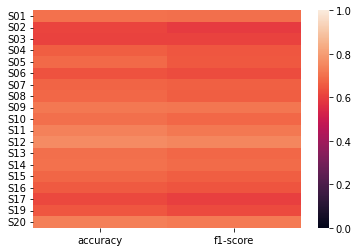

     class0 f1-score  class1 f1-score
S01         0.789474         0.489362
S02         0.734694         0.285714
S03         0.718367         0.355140
S04         0.772563         0.350515
S05         0.798450         0.297297
S06         0.756757         0.307692
S07         0.770428         0.438095
S08         0.782288         0.404040
S09         0.805861         0.485437
S10         0.792727         0.435644
S11         0.826772         0.450000
S12         0.838462         0.543478
S13         0.795455         0.425532
S14         0.793893         0.460000
S15         0.780669         0.391753
S16         0.764045         0.363636
S17         0.744939         0.258824
S19         0.760148         0.329897
S20         0.818182         0.500000


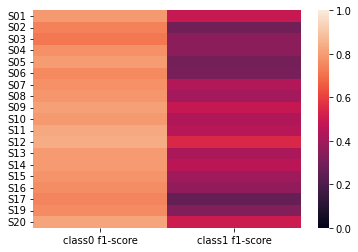

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
model.return_pairwise_weights().shape

(32,)